## Import Package

In [ ]:
%run ./ESE527_project_setup.ipynb

# Predictive Analysis

## Classification without outlier detection

### Split dataset

In [92]:
features=data.drop(['Rating', 'Rating Interval'],axis=1)
label=data['Rating Interval']
standardized_features=Standardization(features)
train_X,test_X,train_Y,test_Y=train_test_split(standardized_features,label,test_size=0.2,random_state=527)
smote = SMOTE()
# Fit and apply SMOTE
train_X, train_Y = smote.fit_resample(train_X, train_Y)

In [93]:
lasso = Lasso(alpha=0.01)
# Fit Lasso model on the training data
lasso.fit(train_X, train_Y)
# Get the coefficients
coefficients = pd.Series(lasso.coef_, index=train_X.columns)
# Filter features with non-zero coefficients
selected_features = coefficients[coefficients != 0].index.tolist()
print('Selected features:', selected_features)
print('Number of selected features:', len(selected_features))
train_X=train_X[selected_features]
test_X=test_X[selected_features]

Selected features: ['Reviews', 'Size', 'Price', 'days_since_last_update', 'Category_ART_AND_DESIGN', 'Category_BOOKS_AND_REFERENCE', 'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION', 'Category_EVENTS', 'Category_GAME', 'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME', 'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL', 'Category_PERSONALIZATION', 'Category_PRODUCTIVITY', 'Category_SOCIAL', 'Category_TOOLS', 'Category_VIDEO_PLAYERS', 'Content Rating_Adults only 18+', 'Content Rating_Mature 17+', 'Content Rating_Unrated', 'Genres_Adventure', 'Genres_Adventure;Action & Adventure', 'Genres_Adventure;Brain Games', 'Genres_Arcade', 'Genres_Arcade;Action & Adventure', 'Genres_Art & Design;Creativity', 'Genres_Art & Design;Pretend Play', 'Genres_Board', 'Genres_Board;Brain Games', 'Genres_Board;Pretend Play', 'Genres_Books & Reference', 'Genres_Casino', 'Genres_Casual', 'Genres_Casual;Brain Games', 'Genres_Comics', 'Genres_Communication', 'Genres_Dating', 'Genres_Educa

In [94]:
model = LogisticRegression(random_state=0)
# Define the grid of values for hyperparameters
params = {
    'C': [0.01,0.1,1,10,100,1000],
    'penalty': ['l2'],
    'solver': ['newton-cg','lbfgs','liblinear','sag']
}
train_X=train_X[selected_features]
test_X=test_X[selected_features]
# Define GridSearchCV
LR_clf = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1)
LR_clf.fit(train_X, train_Y)
# Best parameters and best score
print("Best parameters:", LR_clf.best_params_)
print("Best score:", LR_clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.47855128271428626


In [95]:
# Best model:
LR_clf.best_estimator_.score(test_X[selected_features],test_Y)

0.42693602693602695

Accuracy: 0.42693602693602695
Precision: 0.4698465111164797
Recall: 0.42693602693602695
F1 Score: 0.4133299534522558


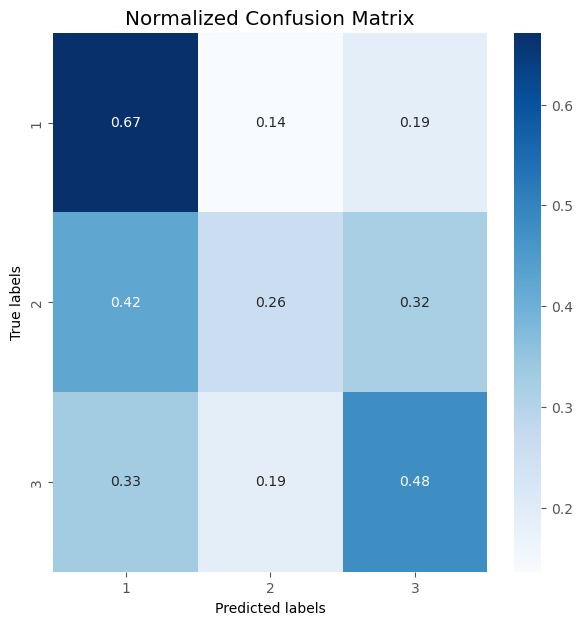

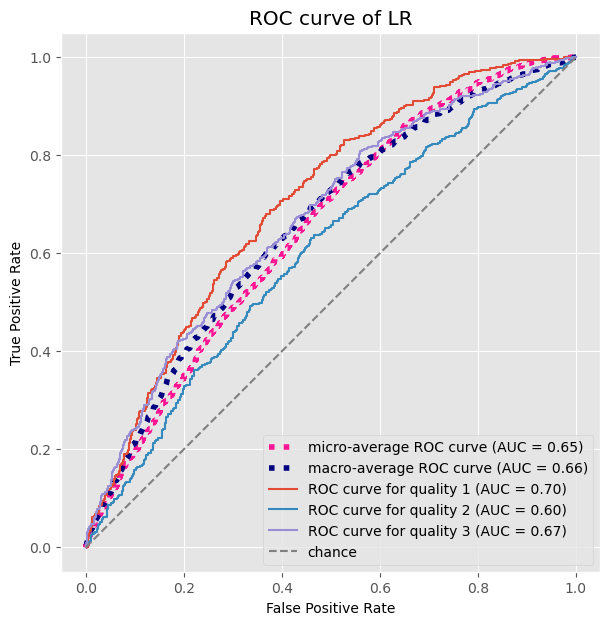

In [96]:
cm(test_X,test_Y,LR_clf)
ROC(train_Y,test_Y,LR_clf,'LR',)

### Random Forest

In [97]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion',['gini', 'entropy']),
        'max_features': trial.suggest_int('max_features', 1, 10),
    }
    RF_clf = RandomForestClassifier(**params)
    RF_clf.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(RF_clf, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-05-04 18:32:44,097] A new study created in memory with name: no-name-da90a093-df12-4f3b-ac17-aacac651eb4a


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-05-04 18:33:02,074] Trial 0 finished with value: 0.501347345728914 and parameters: {'n_estimators': 509, 'criterion': 'entropy', 'max_features': 6}. Best is trial 0 with value: 0.501347345728914.
[I 2024-05-04 18:33:15,979] Trial 1 finished with value: 0.5002694691457829 and parameters: {'n_estimators': 444, 'criterion': 'gini', 'max_features': 5}. Best is trial 0 with value: 0.501347345728914.
[I 2024-05-04 18:33:43,048] Trial 2 finished with value: 0.5064672594987875 and parameters: {'n_estimators': 816, 'criterion': 'gini', 'max_features': 8}. Best is trial 2 with value: 0.5064672594987875.
[I 2024-05-04 18:34:08,717] Trial 3 finished with value: 0.5012126111560227 and parameters: {'n_estimators': 740, 'criterion': 'entropy', 'max_features': 6}. Best is trial 2 with value: 0.5064672594987875.
[I 2024-05-04 18:34:38,426] Trial 4 finished with value: 0.5086230126650498 and parameters: {'n_estimators': 872, 'criterion': 'gini', 'max_features': 9}. Best is trial 4 with value: 0.

In [98]:
clf_RF= RandomForestClassifier(**best_params)
clf_RF.fit(train_X, train_Y)
y_pred=clf_RF.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred)
accuracy

0.5111111111111111

Accuracy: 0.5111111111111111
Precision: 0.5208662972782914
Recall: 0.5111111111111111
F1 Score: 0.5135629703636618


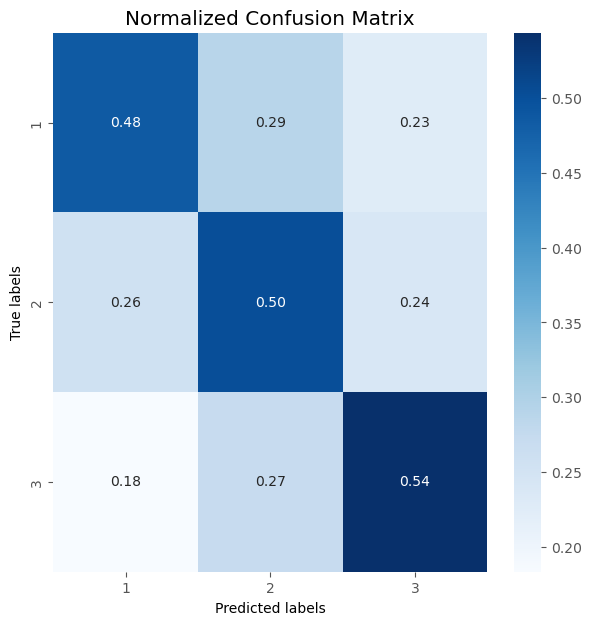

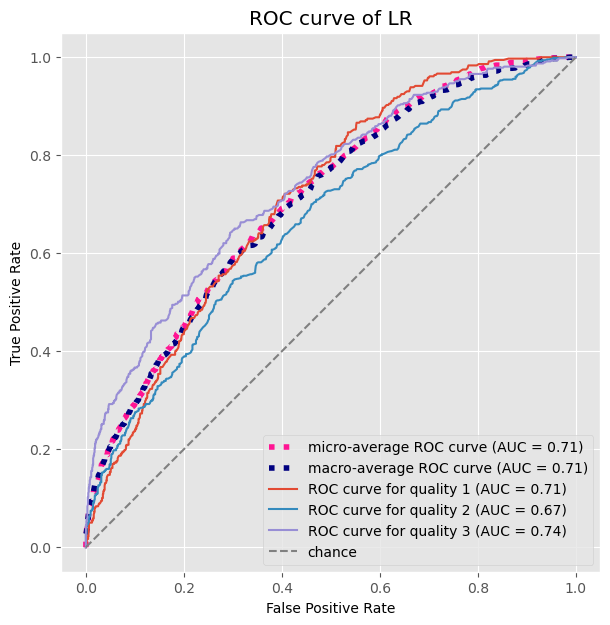

In [99]:
cm(test_X,test_Y,clf_RF)
ROC(train_Y,test_Y,clf_RF,'LR')

### Lightgbm

In [100]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-05-04 18:34:50,379] A new study created in memory with name: no-name-f840fc1d-1583-42f3-9335-7ab34462a443


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8459312653296365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8459312653296365
[LightGBM] [Warning] bagging_fraction is set=0.2683304765688962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2683304765688962
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8459312653296365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8459312653296365
[LightGBM] [Warning] bagging_fraction is set=0.2683304765688962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2683304765688962
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds

In [101]:
clf_lgbm= lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(train_X, train_Y)
y_pred=clf_lgbm.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred)
accuracy

[LightGBM] [Warning] feature_fraction is set=0.885221159214731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.885221159214731
[LightGBM] [Warning] bagging_fraction is set=0.8495421258218561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495421258218561
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.885221159214731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.885221159214731
[LightGBM] [Warning] bagging_fraction is set=0.8495421258218561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495421258218561
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
Yo

0.5070707070707071

In [102]:
importances = clf_lgbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Size                           41689.000000
 2) days_since_last_update         36630.000000
 3) Reviews                        33958.000000
 4) Price                          2665.000000
 5) Category_GAME                  1639.000000
 6) Genres_Entertainment           1507.000000
 7) Category_TOOLS                 1310.000000
 8) Genres_Education               1010.000000
 9) Content Rating_Mature 17+      867.000000
10) Category_MEDICAL               817.000000
11) Type_Free                      761.000000
12) Category_HEALTH_AND_FITNESS    755.000000
13) Category_PRODUCTIVITY          720.000000
14) Category_PERSONALIZATION       683.000000
15) Genres_Sports                  648.000000
16) Category_COMMUNICATION         606.000000
17) Genres_Casual                  593.000000
18) Category_BOOKS_AND_REFERENCE   574.000000
19) Genres_Simulation              482.000000
20) Category_SOCIAL                472.000000
21) Genres_Arcade                  427.000000
22) Category_VIDEO_PLAY

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
Accuracy: 0.509090909090909
Precision: 0.5134575284252506
Recall: 0.509090909090909
F1 Score: 0.5100699171046285


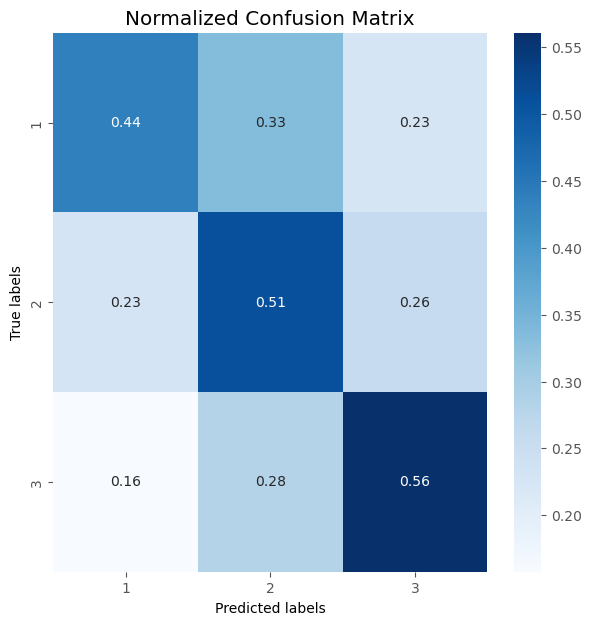

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features


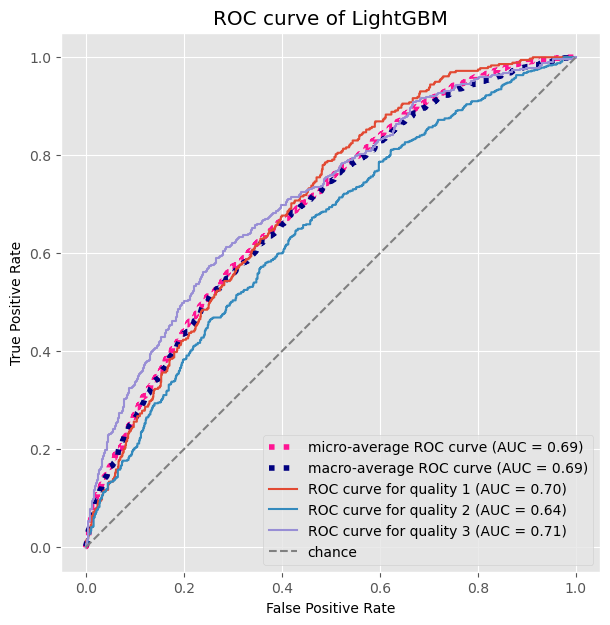

In [71]:
cm(test_X,test_Y,clf_lgbm)
ROC(train_Y,test_Y,clf_lgbm,'LightGBM')